## 第一部分

### 简答题

1. 为什么激活函数是训练一个多层感知机（MLP）的关键要素

没有激活函数，多层神经网络无法学习非线性关系，激活函数可以逼近任意复杂的函数

2. 列举三种常用的激活函数，说明一下它们的大概形状

ReLU
x<0的时候为0，x>0的时候为x

Sigmoid
S型曲线，在0附近陡峭，两端趋于平缓

tanh
S型曲线，范围在-1到1

3. 反向传播的算法解决什么问题，如何工作的

解决多层网络的梯度问题
先前向传播，计算每一层的激活值
在反向传播，根据前向传播保存的激活值和链式法则来计算每一层的梯度
然后更新参数

4. 列出可以在基本MLP（不考虑其他神经网络架构）中进行调整的所有超参数？如果MLP过拟合训练数据，如何调整这些超参数来解决该问题？

隐藏层数量，每层的神经元数量，学习率，激活函数类型，批量大小，训练轮数
减少隐藏层数量或神经元数量，减少训练轮数，降低学习率，增加批量大小

5. 假设有一个MLP，该MLP由一个输入层，10个特征，随后是一个包含50个神经元的隐藏层，最后是3个神经元组成的输出层。所有人工神经元都使用ReLU激活函数。

   a. 输入矩阵X的形状是什么

        (batch_size, 10)

   b. 隐藏层的权重W_hidden及其偏置b_hidden的形状分别是什么
        
        W_hidden(10, 50)
        b_hidden(50,)
    
   c. 输出层的权重W_output及其偏置b_output的形状是什么

        W_hidden(50, 3)
        b_output(3,)

   d. 网络输出矩阵Y的形状是什么

        (batch_size, 3)

   e. 写出输出矩阵Y的计算公式，满足Y是W_hidden, b_hidden, W_output, b_output的函数
   
        Y = ReLU(ReLU(X @ W_hidden + b_hidden) @ W_output + b_output)    

6. 如果要将电子邮件分类为垃圾邮件或正常邮件，需要在输出层中有多少个神经元？应该在输出层中使用什么激活函数？相反，如果想解决MNIST图片分类问题，则在输出层中需要有多少个神经元，应该使用哪种激活函数？如何使神经网络预测 回归话题里提到的房价？

    1个神经元，使用sigmoid激活函数。10个神经元，使用softmax激活函数。无激活函数，使用ReLU激活函数。


### 编程题

在MNIST数据集上训练深度MLP（可以使用tf.keras.datasets.mnist.load_data()加载它）。看看是否可以通过手动调整超参数获得98%以上的精度。

首先尝试使用课堂上介绍的方法搜索最佳学习率（即通过以指数方式增加学习率，根据学习率变化绘制训练损失，并找到损失激增的点）。

接下来，尝试使用Keras Tuner调整超参数——保存检查点，使用早停，并使用TensorBoard绘制学习曲线。

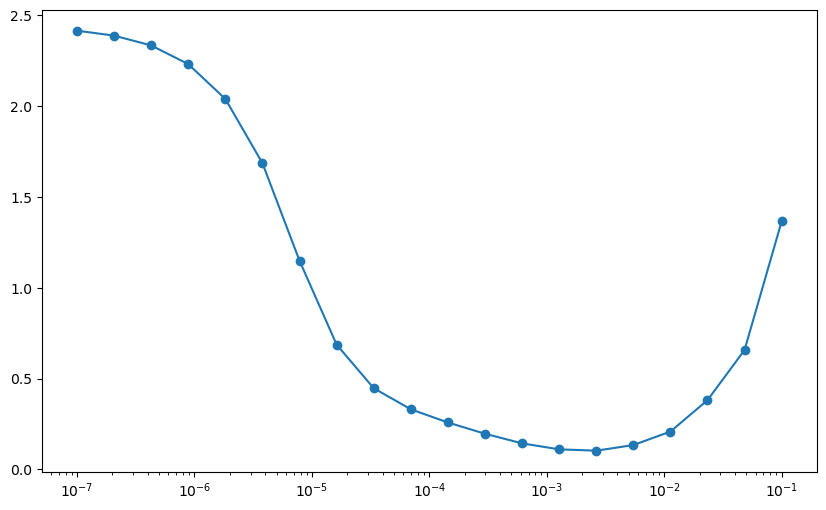

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-7, max_lr=1e-1, steps=20):
        super(myCallback, self).__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.learning_rates = []
        self.losses = []
        self.r = (max_lr/min_lr)**(1/(steps-1))
        
    def on_epoch_begin(self, epoch, logs=None):
        # 设置递增的学习率
        new_lr = self.min_lr * self.r**epoch
        optimizer = self.model.optimizer
        optimizer.learning_rate = new_lr
        
    def on_epoch_end(self, epoch, logs=None):
        optimizer = self.model.optimizer
        current_lr = float(optimizer.learning_rate)
        self.learning_rates.append(current_lr)
        self.losses.append(logs['loss'])
        
    
    def on_train_end(self, logs=None):
        if len(self.learning_rates) > 0 and len(self.losses) > 0:
            plt.figure(figsize=(10, 6))
            plt.plot(self.learning_rates, self.losses, 'o-')
            plt.xscale('log')
            plt.show()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
my_cb = myCallback()
model.fit(
    X_train, y_train, 
    epochs=20, 
    validation_data=(X_test, y_test), 
    callbacks=[my_cb],
    verbose=0
)


In [2]:
best_learning_rate = my_cb.learning_rates[np.argmin(my_cb.losses)] / 10
best_learning_rate

0.00026366508100181816

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
model.fit(
    X_train, y_train, 
    epochs=20, 
    validation_data=(X_test, y_test)
)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8899 - loss: 0.4152 - val_accuracy: 0.9316 - val_loss: 0.2368
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9414 - loss: 0.2090 - val_accuracy: 0.9483 - val_loss: 0.1758
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9556 - loss: 0.1573 - val_accuracy: 0.9579 - val_loss: 0.1405
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9632 - loss: 0.1257 - val_accuracy: 0.9637 - val_loss: 0.1198
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9697 - loss: 0.1037 - val_accuracy: 0.9682 - val_loss: 0.1044
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9756 - loss: 0.0873 - val_accuracy: 0.9703 - val_loss: 0.0977
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9788 - loss: 0.0753 - val_accuracy: 0.9743 - val_loss: 0.0868
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9814 - loss: 0.0657 - 

In [4]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9791 - loss: 0.0727  


[0.07266919314861298, 0.9790999889373779]

In [5]:
import keras_tuner as kt
def build_model(hp):
    n_hidden = hp.Int('num_hidden', min_value=2, max_value=12, step=32)
    n_neurons = hp.Int('num_neurons', min_value=32, max_value=512, step=32)
    learning_rates = hp.Float('learning_rate', min_value=1e-7, max_value=1e-2, sampling='log')
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"]) 
    activation = hp.Choice("activation", values=["relu", "sigmoid", "tanh", "softplus"])
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rates)
    elif optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rates)
        
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [6]:
random_search = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    directory="my_dir",
    project_name="mnist",
    overwrite=True
)
random_search.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Trial 5 Complete [00h 00m 23s]
val_accuracy: 0.9688000082969666

Best val_accuracy So Far: 0.9779000282287598
Total elapsed time: 00h 02m 22s


In [7]:
from pathlib import Path
from time import strftime
def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()
run_logdir

WindowsPath('my_logs/run_2025_09_01_20_56_03')

In [8]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
best_models = random_search.get_best_models(num_models=3)[0]
best_models.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), tensorboard_cb])
best_models.evaluate(X_test, y_test)

C:\Users\31752\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9913 - loss: 0.0300 - val_accuracy: 0.9771 - val_loss: 0.0725
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9935 - loss: 0.0233 - val_accuracy: 0.9781 - val_loss: 0.0698
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9950 - loss: 0.0187 - val_accuracy: 0.9763 - val_loss: 0.0744
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9966 - loss: 0.0141 - val_accuracy: 0.9783 - val_loss: 0.0726
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9970 - loss: 0.0125 - val_accuracy: 0.9779 - val_loss: 0.0758
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9978 - loss: 0.0098 - val_accuracy: 0.9780 - val_loss: 0.0742
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9984 - loss: 0.0074 - val_accuracy: 0.9788 - val_loss: 0.0743
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9788 - loss: 0.0743  


[0.07433544099330902, 0.9787999987602234]

In [10]:
!kill 46064

kill: 46064: No such process


In [11]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


kill: 46064: No such process


## 第二部分

第二部分要求构建一个基本的softmax回归算法，以及一个简单的两层神经网络。将使用原生Python（使用numpy库），不借助keras实现这些算法

在此过程中，将提供一些关于如何实现这些不同函数的指导，但总体而言，细节需要自己实现。 应该尽量使用 numpy 中的线性代数调用：for/while循环通常会使代码运行速度比预期慢得多。

**请仔细阅读作业说明!!!**

去命令行（cmd/Anaconda Powershell Prompt /其他终端）运行如下指令（激活开发环境一定要最先执行），安装这部分作业依赖的python库：
- 激活开发环境：conda activate homl3
- 安装numdifftools：conda install numdifftools
- 安装pytest：conda install pytest


### 第一题：简单的加法函数，以及使用pytest测试代码

为了说明这部分作业的代码+数据，以及pytest使用，将使用一个实现 add函数 的简单示例。

```
data/
    train-images-idx3-ubyte.gz
    train-labels-idx1-ubyte.gz
    t10k-images-idx3-ubyte.gz
    t10k-labels-idx1-ubyte.gz
src/
    simple_ml.py
tests/
    test_simple_ml.py
```

data/ 目录包含这部分作业所需的数据（MNIST 数据集的副本）；src/ 目录包含实现功能所需的源代码；tests/ 目录包含用于测试实现代码是否正确的代码

第一题要求实现 src/目录里 simple_ml.py内的 add函数（这个简单的函数实际上并没有用到，它只是一个帮助熟悉作业结构的示例）。查看 src/simple_ml.py 文件，将找到 add() 函数的定义

```python
def add(x, y):
    """一个简单的add函数，以便熟悉自动测试（pytest）

    Args:
        x (Python数字 或者 numpy array)
        y (Python数字 或者 numpy array)

    Return:
        x+y的和
    """
    ### 你的代码开始
    pass
    ### 你的代码结束
```

函数内的文档字符串（docstring）定义了函数应该产生的预期输入和输出（需要养成仔细阅读文档的习惯，很多错误来源就是没有阅读规范）。实现这个函数。你只需将 pass 语句替换为正确的代码即可，即：

```python
def add(x, y):
    """一个简单的add函数，以便熟悉自动测试（pytest）

    Args:
        x (Python数字 或者 numpy array)
        y (Python数字 或者 numpy array)

    Return:
        x+y的和
    """
    ### 你的代码开始
    return x + y
    ### 你的代码结束
```

现在可以去src/simple_nn.py里，把add函数里的pass 换成 return x + y

#### 测试代码

现在需要测试一下你的代码是否能正确运行，正确运行才说明实现没问题。

在这部分作业中，将使用pytest对代码进行单元测试。在 src/simple_ml.py 文件中 写完 add函数的实现后，去命令行里确保已经激活了homl3环境（conda activate homl3）， 确保homl3环境里安装过了numdifftools和pytest，确定命令行里显示的文件路径在 作业8的目录（这个目录同时有data/, src/和tests/文件夹），然后执行以下命令：

python -m pytest -k "add"

如果一切正常，你会看到类似这样的图片：
![测试add通过](../../images/homework/neural_network/p1.png)

想看测试如何进行的，可以去查看tests/test_simple_ml.py文件，python -m pytest -k "add"指令刚刚运行的是 文件里的test_add() 函数

如果错误地实现了某些内容（例如，将上面的 x + y 更改为 x - y），那么测试将会失败，并且 pytest 将会指示相应的测试失败。

比如把x+y，换成x-y后，执行python -m pytest -k "add"：
![测试add不通过](../../images/homework/neural_network/p2.png)

b如图所见，将收到一个错误，指示断言失败，然后就可以使用它来返回并调整实现代码。应该能够熟练地阅读和跟踪测试文件，以便更好地理解正确的实现应该如何工作

学习正确开发和使用单元测试对于现代软件开发至关重要，希望这次作业帮助了解单元测试在软件开发中的典型用法。

当然，这次作业不一定需要编写自己的测试去确保自己实现正确，但应该熟悉如何阅读提供的测试文件，以便了解要实现的函数应该如何运行。但是，也绝对鼓励为自己的实现编写额外的测试。

如果习惯通过打印语句调试代码，请注意，pytest 默认会捕获任何输出（隐藏掉测试代码执行的print）。可以通过将 -s 传递给 pytest 来禁用此行为并让测试在所有情况下显示所有输出。

b### 第二题：用gzip和struct处理压缩文件和二进制数据，加载MNIST数据


现在已经熟悉了测试工具pytest，接下来在 src/simple_nn.py 中需要实现的函数上尝试一下：parse_mnist_data() 函数。

这个函数也有文档字符串（docstring），请仔细阅读它们。

然后，请访问 https://web.archive.org/web/20220509025752/http://yann.lecun.com/exdb/mnist/ 了解 MNIST 数据的二进制格式。然后编写函数读取此类文件，并根据文档字符串中的规范返回 numpy 数组）。建议使用 Python 中的 struct 模块（以及 gzip 模块，当然还有 numpy 本身）来实现此函数。

当然可以利用AI搜索这个部分的代码实现，但了解了MNIST数据的二进制格式和gzip，struct的简单使用后，能理解AI产出的代码为什么正确

实现函数后，去命令行运行本地单元测试， 同样确保命令行激活了homl3环境，确保路径在作业8目录下（有data/,src/和tests/ 文件夹）， 后面的题不再强调

python -m pytest -k "parse_mnist"

### 第三题：Softmax损失

在 `src/simple_ml.py` 文件的 `softmax_loss()` 函数中实现 softmax（也称为交叉熵）损失。对于一个可以取值 $ y \in \{1, \ldots, k\} $ 的多类输出，softmax 损失接收一个对数几率向量 $ z \in \mathbb{R}^k $ 和真实类别 $ y \in \{1, \ldots, k\} $ 作为输入，并返回由以下公式定义的损失：

$\ell_{\text{softmax}}(z, y) = \log (\sum_{i=1}^{k} \exp z_i) - z_y$

对数几率向量z，可以看成被softmax激活之前的值，对公式有疑惑，或者对z的意义有疑惑的，可以参考softmax回归的笔记，并自己推导一下损失公式是否正确

请注意，如其文档字符串（docstring）所述，`softmax_loss()` 函数接收一个二维的对数几率数组（即，一批不同样本的 $ k $ 维对数几率）加上一个对应的一维真实标签数组，并应返回整批样本的平均 softmax 损失。请注意，为了正确实现此功能，你不应使用任何循环，而是完全使用 numpy 的向量化操作进行计算（为此设定预期，实现代码可以少到一行代码）。

实现完成后，可以去命令行进行单元测试：python -m pytest -k "softmax_loss"

### 第四题：softmax回归小批量梯度下降

在这个问题中，你将实现（线性）softmax 回归的小批量梯度下降）。考虑一个假设函数，该函数通过以下公式将 $ n $ 维输入转换为 $ k $ 维对数几率：

$h(x) = \Theta^T x$

其中 $ x \in \mathbb{R}^n $ 是输入，$\Theta \in \mathbb{R}^{n \times k}$ 是模型参数。给定数据集 $\{(x^{(i)} \in \mathbb{R}^n, y^{(i)} \in \{1, \ldots, k\})\}$，其中 $ i = 1, \ldots, m $，softmax 回归相关的优化问题因此由下式给出：

$\text{minimize} \frac{1}{m} \sum_{i=1}^{m} \ell_{\text{softmax}} (\Theta^T x^{(i)}, y^{(i)})$

线性 softmax 目标的梯度由下式给出，有疑惑的可以结合softmax回归的笔记验证

$\nabla_\Theta \ell_{\text{softmax}} (\Theta^T x, y) = x(z - e_y)^T$

其中

$z = \frac{\exp(\Theta^T x)}{1^T \exp(\Theta^T x)} = \text{normalize}(\exp(\Theta^T x))$

（即 $ z $ 只是归一化的 softmax 概率），并且 $ e_y $ 表示 y 分类的独热编码，即一个所有元素为零，只有第 $ y $ 个位置为 1 的向量。

也可以用更紧凑的符号来表示，方便代码实现，即，如果让 $ X \in \mathbb{R}^{m \times n} $ 表示某个 $ m $ 个输入的特征矩阵（整个数据集或一个小批量），$ y \in \{1, \ldots, k\}^m $ 是对应的标签向量，并且 $ \ell_{\text{softmax}} $ 表示平均 softmax 损失，那么

$\nabla_\Theta \ell_{\text{softmax}}(X \Theta, y) = \frac{1}{m} X^T (Z - I_y)$

其中

$Z = \text{normalize}(\exp(X \Theta)) \quad (\text{归一化按行应用})$

表示对数几率矩阵，而 $ I_y \in \mathbb{R}^{m \times k} $ 表示 $ y $ 中标签的 逐个转成 独热编码，按行连接

使用这些梯度，实现 `softmax_regression_epoch()` 函数，该函数使用指定的学习率/步长 $ \eta $ 和小批量大小 `batch_size` 运行单个轮次（对数据集的一次遍历）。如其文档字符串所述，你的函数应该就地修改 Theta 数组。实现后，请去命令行运行测试。

python -m pytest -k "softmax_regression_epoch"

#### 用softmax回归训练MNIST

虽然这不包含在测试中，但既然你已经编写了这段代码，你也可以尝试使用 SGD 训练一个完整的 MNIST 线性分类器。为此，你可以使用 src/simple_ml.py 文件中的 train_softmax() 函数（已经编写好了这个函数，所以无需自行编写，但可以查看一下它的功能）。

可以使用以下代码了解它的工作原理。作为参考，如下所示，我的实现在 notebook 上运行时间约为 2 秒，测试集错误率为 7.97%。

In [12]:
import sys
sys.path.append("src/")
from simple_nn import train_softmax, parse_mnist

X_tr, y_tr = parse_mnist("data/train-images-idx3-ubyte.gz",
                         "data/train-labels-idx1-ubyte.gz")
X_te, y_te = parse_mnist("data/t10k-images-idx3-ubyte.gz",
                         "data/t10k-labels-idx1-ubyte.gz")

train_softmax(X_tr, y_tr, X_te, y_te, epochs=10, lr=0.2, batch=100)

| Epoch | Train Loss | Train Err | Test Loss | Test Err |
|     0 |    0.35134 |   0.10182 |   0.33588 |  0.09400 |
|     1 |    0.32142 |   0.09268 |   0.31086 |  0.08730 |
|     2 |    0.30802 |   0.08795 |   0.30097 |  0.08550 |
|     3 |    0.29987 |   0.08532 |   0.29558 |  0.08370 |
|     4 |    0.29415 |   0.08323 |   0.29215 |  0.08230 |
|     5 |    0.28981 |   0.08182 |   0.28973 |  0.08090 |
|     6 |    0.28633 |   0.08085 |   0.28793 |  0.08080 |
|     7 |    0.28345 |   0.07997 |   0.28651 |  0.08040 |
|     8 |    0.28100 |   0.07923 |   0.28537 |  0.08010 |
|     9 |    0.27887 |   0.07847 |   0.28442 |  0.07970 |


### 在1个隐藏层的神经网络上进行小批量梯度下降

现在已经为线性分类器编写了SGD，现在考虑一个简单的两层神经网络的情况。具体来说，对于输入 $ x \in \mathbb{R}^n $，考虑一个形式如下的两层神经网络（无偏置项）：

$ z = W_2^T ReLU(W_1^T x) $

其中 $ W_1 \in \mathbb{R}^{n \times d} $ 和 $ W_2 \in \mathbb{R}^{d \times k} $ 表示网络的权重（具有 $ d $ 维隐藏单元），而 $ z \in \mathbb{R}^k $ 表示网络输出的对数几率。我们再次使用 softmax/交叉熵损失，这意味着我们要解决以下优化问题：

$\text{minimize } \frac{1}{W_1, W_2} \sum_{i=1}^m \ell_{\text{softmax}}(W_2^T ReLU(W_1^T x^{(i)}), y^{(i)})$

或者，使用矩阵 $ X \in \mathbb{R}^{m \times n} $ 来描述批量形式，这也可以写成：

$\text{minimize } \ell_{\text{softmax}}(ReLU(XW_1)W_2, y)$

使用链式法则，可以推导出该网络的反向传播更新（为了便于实现，这里提供最终形式）。具体来说，令：

$Z_1 \in \mathbb{R}^{m \times d} = ReLU(XW_1)$

$G_2 \in \mathbb{R}^{m \times k} = \text{normalize}(\exp(Z_1 W_2)) - I_y$

$G_1 \in \mathbb{R}^{m \times d} = 1\{Z_1 > 0\} \circ (G_2 W_2^T)$

其中 $ 1\{Z_1 > 0\} $ 是一个二进制矩阵，其条目根据 $ Z_1 $ 中的每个项是否严格为正而等于零或一，而 $\circ$ 表示逐元素乘法。那么目标的梯度由下式给出：

$\nabla_{W_1} \ell_{\text{softmax}}(ReLU(XW_1)W_2, y) = \frac{1}{m} X^T G_1$

$\nabla_{W_2} \ell_{\text{softmax}}(ReLU(XW_1)W_2, y) = \frac{1}{m} Z_1^T G_2$

**注意：** 如果这些精确方程的细节对你来说有点神秘，不必太担心。这些只是两层ReLU网络的标准反向传播方程：$ Z_1 $ 项只是计算"前向"传播，而 $ G_2 $ 和 $ G_1 $ 项表示反向传播。但是更新的精确形式可能会因你使用的神经网络符号、制定损失函数的具体方式、是否之前以矩阵形式推导过这些等因素而有所不同。（毕竟，在某种程度上，深度学习系统（比如tensorflow）的整个重点是我们不需要费心进行这些手动计算）。


使用这些梯度，现在在 src/simple_ml.py 文件中编写 nn_epoch() 函数。与上一个问题一样，你的解决方案应该修改 W1 和 W2 数组。实现该函数后，运行以下测试。请务必使用上述表达式所示的矩阵运算来实现该函数：这比尝试使用循环更快、更高效（并且所需的代码也更少）。

实现完成后，去命令运行单元测试：python -m pytest -k "nn_epoch"

#### 训练神经网络

In [14]:
import sys


import importlib
import simple_nn
importlib.reload(simple_nn) # 重新载入simple_nn， 防止刚才的训练代码产生了缓存，影响了simple_nn

sys.path.append("src/")
from simple_nn import train_nn, parse_mnist

X_tr, y_tr = parse_mnist("data/train-images-idx3-ubyte.gz",
                         "data/train-labels-idx1-ubyte.gz")
X_te, y_te = parse_mnist("data/t10k-images-idx3-ubyte.gz",
                         "data/t10k-labels-idx1-ubyte.gz")
train_nn(X_tr, y_tr, X_te, y_te, hidden_dim=400, epochs=20, lr=0.2)

| Epoch | Train Loss | Train Err | Test Loss | Test Err |
|     0 |    0.15324 |   0.04697 |   0.16305 |  0.04920 |
|     1 |    0.09854 |   0.02923 |   0.11604 |  0.03660 |
|     2 |    0.07428 |   0.02180 |   0.09767 |  0.03200 |
|     3 |    0.05936 |   0.01732 |   0.08745 |  0.02850 |
|     4 |    0.04856 |   0.01362 |   0.08133 |  0.02570 |
|     5 |    0.04032 |   0.01088 |   0.07661 |  0.02400 |
|     6 |    0.03473 |   0.00887 |   0.07416 |  0.02310 |
|     7 |    0.03030 |   0.00760 |   0.07234 |  0.02320 |
|     8 |    0.02669 |   0.00653 |   0.07117 |  0.02240 |
|     9 |    0.02371 |   0.00552 |   0.06998 |  0.02140 |
|    10 |    0.02124 |   0.00488 |   0.06929 |  0.02140 |
|    11 |    0.01894 |   0.00403 |   0.06812 |  0.02140 |
|    12 |    0.01705 |   0.00313 |   0.06756 |  0.02110 |
|    13 |    0.01556 |   0.00270 |   0.06719 |  0.02140 |
|    14 |    0.01423 |   0.00240 |   0.06685 |  0.02090 |
|    15 |    0.01298 |   0.00215 |   0.06645 |  0.02100 |
|    16 |    0

作为参考，我的实现花了30多秒训练，最终在mnist的测试集达到了1.93%的错误率，只用了大概20多行代码